# Imperfect modeling + Sobolev regularization example

This notebook reproduces the experiment from _Convergence and error analysis of PINNs_, Doumèche et al., 2023 [link](https://arxiv.org/pdf/2305.01240.pdf). In particular, the article introduces a _Sobolev regularization_ over the neural network. The original code is [here](https://github.com/NathanDoumeche/Convergence_and_error_analysis_of_PINNs/tree/main/Section_5).

$\Omega = ]0,1[$, $ I=[0, 1]$ and we get observations simulated from the model:

$$
Y = u^*(X) + \mathcal{N}(0, 10^-2), \text{ where } u^*(t, x)=\exp(t - x) + 0.1\cos(2\pi x).
$$

We are in the context of imperfect modeling (_i.e._, there is some modeling error) since we posit an advection model:

$$
\begin{cases}
\frac{\partial u(t,x)}{\partial x} + \frac{\partial u}{\partial t}(t,x)=0\\
u(0, x)=\exp(-x), \forall x\in ]0,1[\\
u(t, 0)=\exp(t),\forall t\in ]0,1[\\
\end{cases}
$$
Since the unique solution of this advection model is $u_{\mathrm{model}}=\exp{(t-x)}\neq u^*$, we are in the imperfect modeling scenario.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

## Create observations

In [5]:
def u_star(t, x):
    return jnp.exp(t - x) + 0.1 * jnp.cos(2 * jnp.pi * x)

In [6]:
n = 1000
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
t_obs = jax.random.uniform(subkey1, (n, ), minval=0.001, maxval=0.5)
x_obs = jax.random.uniform(subkey2, (n, ), minval=0.001, maxval=1.)
obs = u_star(t_obs, x_obs) + jax.random.normal(subkey3, (n,)) * jnp.sqrt(1e-2)

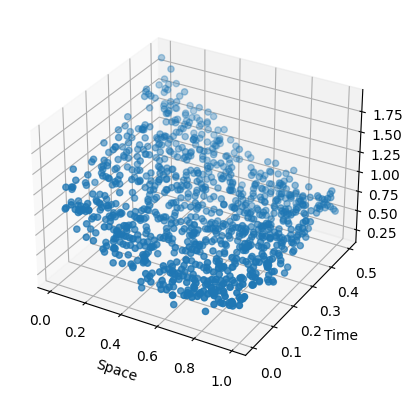

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_obs, t_obs, obs)
ax.set_xlabel("Space")
ax.set_ylabel("Time")
#ax.view_init(elev=10., azim=0)
plt.show()

## Visualize $u_{\mathrm{model}}$ and $u^*$

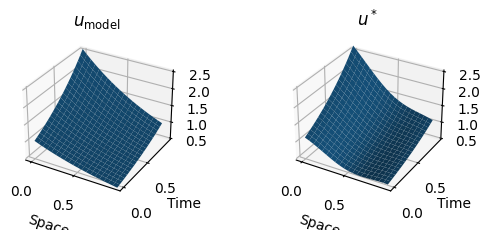

In [8]:
def u_model(t, x):
    return jnp.exp(t - x)

fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
t = x = jnp.arange(0, 1, 0.05)
T, X = jnp.meshgrid(t, x)
zs = jnp.array(u_model(jnp.ravel(T), jnp.ravel(X)))
Z = zs.reshape(X.shape)

ax1.plot_surface(X, T, Z)

ax1.set_xlabel('Space')
ax1.set_ylabel('Time')
ax1.set_zlabel('')
ax1.set_title(r"$u_{\mathrm{model}}$")
ax1.set_zlim((0.5, 2.5))


ax2 = fig.add_subplot(222, projection='3d')

zs = jnp.array(u_star(jnp.ravel(T), jnp.ravel(X)))
Z = zs.reshape(X.shape)

ax2.plot_surface(X, T, Z)

ax2.set_xlabel('Space')
ax2.set_ylabel('Time')
ax2.set_zlabel('')
ax2.set_title(r"$u^*$")
ax2.set_zlim((0.5, 2.5))
plt.show()

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [9]:
eqx_list = [
    [eqx.nn.Linear, 2, 100],
    [jax.nn.tanh],
    [eqx.nn.Linear, 100, 100],
    [jax.nn.tanh],
    [eqx.nn.Linear, 100, 1],
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [10]:
init_nn_params = init_param_fn()

Create a DataGenerator object

In [11]:
n = 100
nt = 100
nb = 2
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 1
dim = 1
xmin = 0.001
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

Let's plot the initial condition

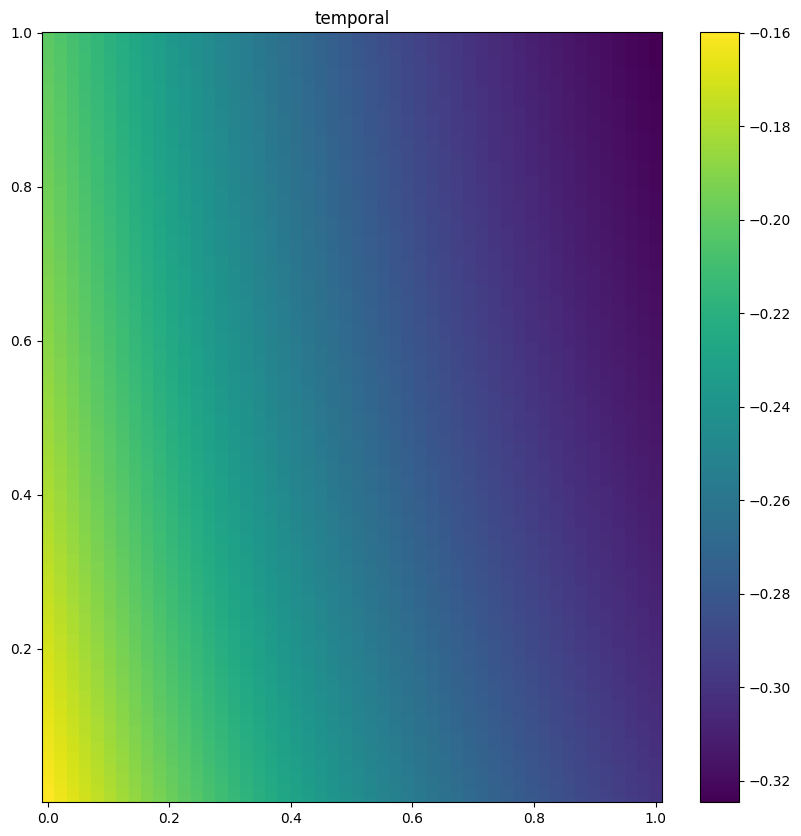

In [12]:
u_init = partial(u, u_params=init_nn_params)
Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

## Model parameters

In [13]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
    }
}

## Initial and boundary conditions

Text(0.5, 1.0, 'Initial condition ($t=0$)')

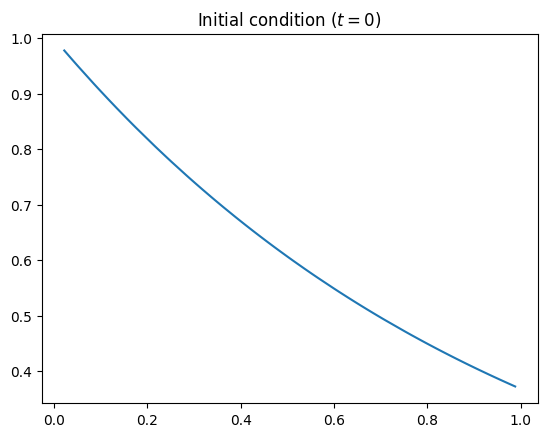

In [14]:
def u_init(x):
    return jnp.exp(-x)

plt.plot(train_data.omega.sort(axis=0), vmap(u_init, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Initial condition ($t=0$)")

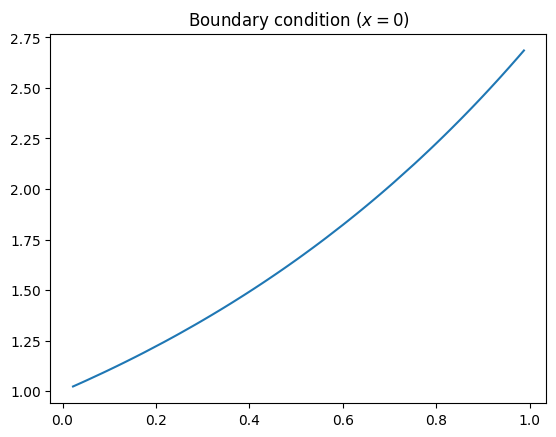

In [15]:
def u_boundary(t, dx):
    return jnp.exp(t)

plt.plot(train_data.omega.sort(axis=0), vmap(u_boundary, (0, None), 0)(train_data.omega.sort(axis=0), None))
plt.title(r"Boundary condition ($x=0$)")

omega_boundary_fun = {
    "xmin": u_boundary,
    "xmax": None
}
omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": None
}

## Physics prior: advection equation

In [16]:
from jinns.loss import PDENonStatio

class advection_loss(PDENonStatio):
    def __init__(self, Tmax=1, derivatives="nn_params", eq_params_heterogeneity=None):
        super().__init__(Tmax, derivatives, eq_params_heterogeneity)
    def evaluate(self, t, x, u, params):
        nn_params, eq_params = self.set_stop_gradient(params)
        du_dt = jax.grad(u, 0)
        du_dx = jax.grad(u, 1)

        return du_dt(t, x, nn_params, eq_params)[0] + du_dx(t, x, nn_params, eq_params)[0]

dynamic_loss = advection_loss(Tmax=Tmax)

## Learning the neural network parameters without Sobolev regularization

In [17]:
lambda_d = jnp.sqrt(10 * n)
loss_weights = {"dyn_loss":1, "temporal_loss":1, "boundary_loss":1, "observations":lambda_d}
    
loss_no_sobolev = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    temporal_boundary_fun=u_init,
    obs_batch=[t_obs, x_obs, obs],
)

In [18]:
params_no_sobolev = init_params
# Optimizer
import optax
lambda_ = 1 / jnp.sqrt(10000)

tx = optax.adamw(learning_rate=1e-3, weight_decay=lambda_)
n_iter = int(30000)

In [19]:
params_no_sobolev, total_loss_list, loss_by_term_dict, train_data, loss_no_sobolev, _, _ = jinns.solve(
    init_params=params_no_sobolev,
    data=train_data,
    optimizer=tx,
    loss=loss_no_sobolev,
    n_iter=n_iter,
    print_loss_every=500
)

Iteration 0: loss value = 28.642053604125977


  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 500: loss value = 1.0559139251708984
Iteration 1000: loss value = 1.0278514623641968
Iteration 1500: loss value = 0.9577161073684692
Iteration 2000: loss value = 0.8890712857246399
Iteration 2500: loss value = 0.8015511631965637
Iteration 3000: loss value = 0.8357184529304504
Iteration 3500: loss value = 0.8365625143051147
Iteration 4000: loss value = 0.8455850481987
Iteration 4500: loss value = 0.8975217938423157
Iteration 5000: loss value = 0.8988813161849976
Iteration 5500: loss value = 0.9279527068138123
Iteration 6000: loss value = 0.9031481742858887
Iteration 6500: loss value = 0.9040255546569824
Iteration 7000: loss value = 0.9012891054153442
Iteration 7500: loss value = 0.8896588683128357
Iteration 8000: loss value = 0.9125280976295471
Iteration 8500: loss value = 0.9113435745239258
Iteration 9000: loss value = 0.9393166303634644
Iteration 9500: loss value = 0.9079509973526001
Iteration 10000: loss value = 0.9120187163352966
Iteration 10500: loss value = 0.90930068492

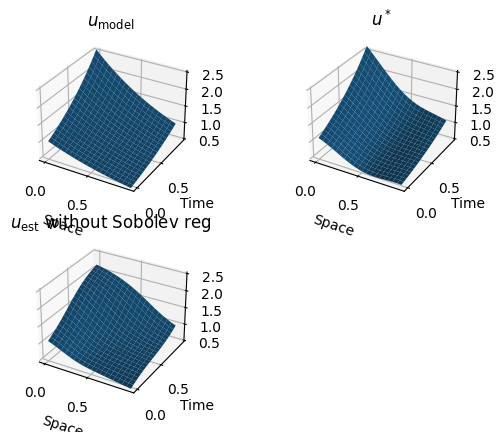

In [20]:
u_est = lambda t, x, p:u(t, x, p)
v_u_est = vmap(u_est, (0, 0, None))
ax3 = fig.add_subplot(223, projection='3d')

zs = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_no_sobolev["nn_params"]))
Z = zs.reshape(X.shape)

ax3.plot_surface(X, T, Z)

ax3.set_xlabel('Space')
ax3.set_ylabel('Time')
ax3.set_zlabel('')
ax3.set_title(r"$u_{\mathrm{est}}$ without Sobolev reg")
ax3.set_zlim((0.5, 2.5))

#ax3.view_init(elev=10., azim=20)

fig

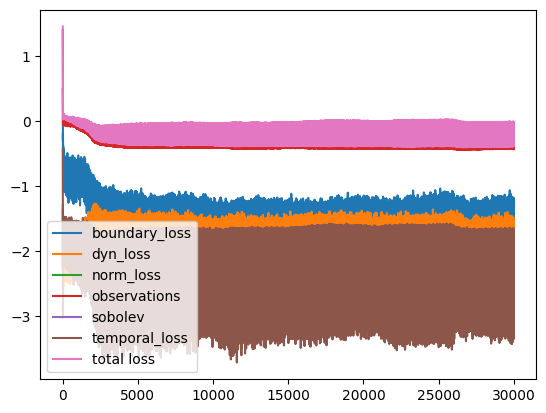

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

## Learning the neural network parameters with Sobolev regularization

In [22]:
lambda_t = 0.1 / jnp.log(n)
loss_weights = {"dyn_loss":1, "temporal_loss":1, "boundary_loss":1, "observations":lambda_d, "sobolev":lambda_t}
    
loss_sobolev = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    temporal_boundary_fun=u_init,
    obs_batch=[t_obs, x_obs, obs],
    sobolev_m=1
)

In [23]:
params_sobolev = init_params

In [24]:
# Optimizer
import optax
lambda_ = 1 / jnp.sqrt(10000)

tx = optax.adamw(learning_rate=1e-3, weight_decay=lambda_)

In [25]:
n_iter = int(30000)

In [26]:
params_sobolev, total_loss_list, loss_by_term_dict, train_data, loss_sobolev, _, _ = jinns.solve(
    init_params=params_sobolev,
    data=train_data,
    optimizer=tx,
    loss=loss_sobolev,
    n_iter=n_iter,
    print_loss_every=500
)

2023-11-07 17:17:16.350639: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:523] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /usr/local/cuda-12.0
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 0: loss value = 28.72957420349121
Iteration 500: loss value = 1.1053680181503296
Iteration 1000: loss value = 1.0088472366333008
Iteration 1500: loss value = 0.8812260031700134
Iteration 2000: loss value = 0.9620546698570251
Iteration 2500: loss value = 0.9361716508865356
Iteration 3000: loss value = 0.9466853141784668
Iteration 3500: loss value = 0.9167747497558594
Iteration 4000: loss value = 0.9767875075340271
Iteration 4500: loss value = 1.003471851348877
Iteration 5000: loss value = 1.0145621299743652
Iteration 5500: loss value = 1.0364043712615967
Iteration 6000: loss value = 1.0555508136749268
Iteration 6500: loss value = 1.0546889305114746
Iteration 7000: loss value = 1.033989667892456
Iteration 7500: loss value = 1.005731463432312
Iteration 8000: loss value = 1.003576397895813
Iteration 8500: loss value = 1.0183117389678955
Iteration 9000: loss value = 1.0172781944274902
Iteration 9500: loss value = 0.9794992208480835
Iteration 10000: loss value = 1.001001000404358
I

## Results

Plot the loss values

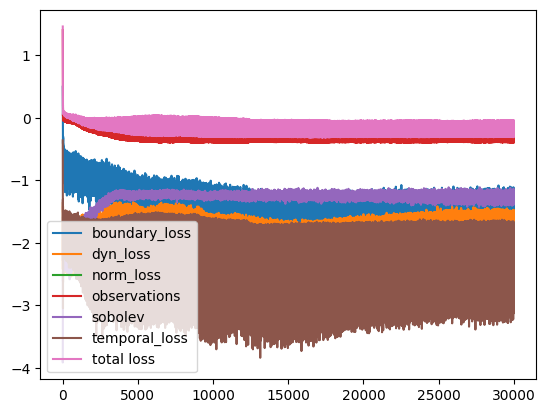

In [27]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

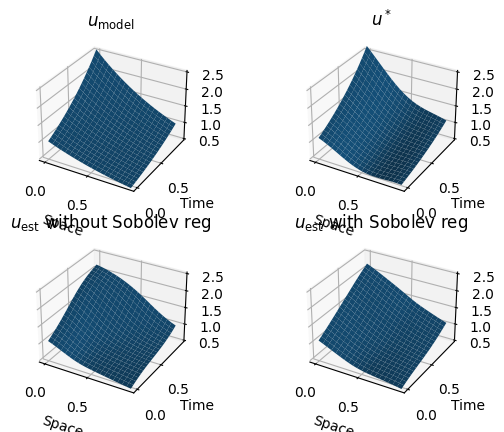

In [28]:
u_est = lambda t, x, p:u(t, x, p)
v_u_est = vmap(u_est, (0, 0, None))
ax4 = fig.add_subplot(224, projection='3d')

zs = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_sobolev["nn_params"]))
Z = zs.reshape(X.shape)

ax4.plot_surface(X, T, Z)

ax4.set_xlabel('Space')
ax4.set_ylabel('Time')
ax4.set_zlabel('')
ax4.set_title(r"$u_{\mathrm{est}}$ with Sobolev reg")
ax4.set_zlim((0.5, 2.5))
fig

## Performance comparison

MSE without Sobolev regularization 0.008903453
MSE with Sobolev regularization 0.008411464


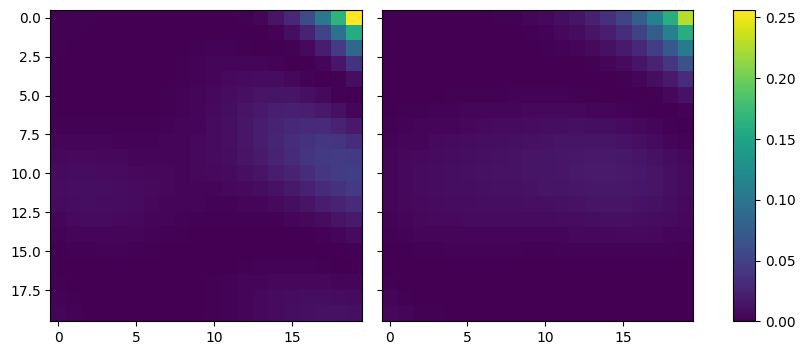

In [29]:
values_no_sobolev = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_no_sobolev["nn_params"]))
values_sobolev = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_sobolev["nn_params"]))
values_true = jnp.array(u_star(jnp.ravel(T), jnp.ravel(X)))

no_sobolev = (values_true - values_no_sobolev) ** 2
sobolev = (values_true - values_sobolev) ** 2
max_error = jnp.amax(jnp.stack([no_sobolev, sobolev]))

print("MSE without Sobolev regularization", jnp.mean(no_sobolev))
print("MSE with Sobolev regularization", jnp.mean(sobolev))

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(
    fig,
    122,
    nrows_ncols=(1, 2),
    axes_pad=0.2,
    share_all=True,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.4,
)

im = grid[0].imshow(((values_true - values_no_sobolev) ** 2).reshape(X.shape), vmin=0, vmax=max_error)

im = grid[1].imshow(((values_true - values_sobolev) ** 2).reshape(X.shape), vmin=0, vmax=max_error)
grid[1].cax.colorbar(im)

plt.show()

Note: no observation after $t>0.5$.